In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

### Create dataset

In [3]:
mnist_train_dataset = datasets.MNIST(root=".", download=True, train=True,
                               transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                           ]))

mnist_valid_dataset = datasets.MNIST(root=".", download=True, train=False,
                               transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                           ]))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.12MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
# https://discuss.pytorch.org/t/attributeerror-subset-object-has-no-attribute-targets/66564/5

from torch.utils.data import Dataset

class MNIST_consecutive_2digits(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
        labels(sequence) : targets as required for the indices. will be the same length as indices
    """
    def __init__(self, dataset, indices, labels):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.targets = labels
        self.data = dataset.tensors[0]

    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        target = self.targets[idx]
        return (image, target)

    def __len__(self):
        return len(self.targets)

In [5]:
def create_mnist_2consecutive_digits_dataset(mnist_dataset):
  labels = mnist_dataset.targets.numpy()
  data = mnist_dataset.data.numpy()

  n_pairs = len(labels) // 2
  data, labels = data[:n_pairs * 2], labels[:n_pairs * 2]

  data_2digits = np.array(np.split(data, n_pairs))
  labels_2digits = np.array(np.split(labels, n_pairs))

  labels_2digits_sum = np.sum(labels_2digits, axis=1)  # 2つの数字の和
  labels_2digits_sum[labels_2digits_sum >= 10] -= 10  # 1の桁をラベルとする

  X = torch.tensor(data_2digits, dtype=torch.float32)
  X = torch.unsqueeze(X, dim=2)  # [batch, seqlen, height, width] -> [batch, seqlen, 1, height, width]
  y = torch.tensor(labels_2digits_sum, dtype=torch.long)

  indices = np.arange(len(y))
  return MNIST_consecutive_2digits(TensorDataset(X, y), indices, y)

In [6]:
train_dataset = create_mnist_2consecutive_digits_dataset(mnist_train_dataset)
valid_dataset = create_mnist_2consecutive_digits_dataset(mnist_valid_dataset)

In [7]:
len(train_dataset), len(valid_dataset)

(30000, 5000)

In [8]:
# ラベルの分布の確認
np.unique(train_dataset.targets.numpy(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([2922, 3152, 2986, 3029, 2972, 3051, 2923, 2983, 2915, 3067]))

In [9]:
np.unique(valid_dataset.targets.numpy(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([463, 591, 439, 591, 442, 553, 436, 549, 424, 512]))

In [10]:
# 入力データの次元の確認
train_dataset[0][0].shape

torch.Size([2, 1, 28, 28])

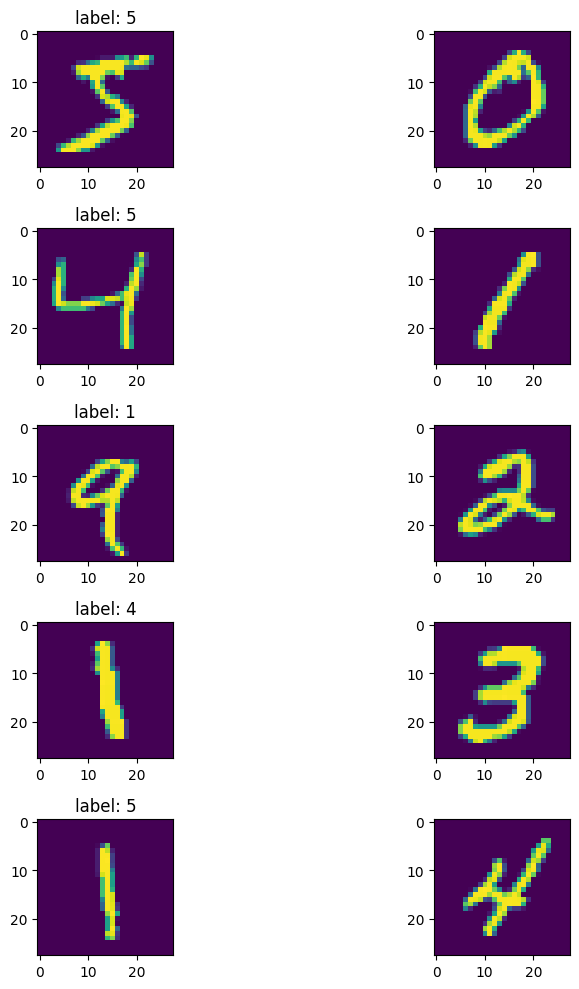

In [11]:
# 入力データとラベルの確認
plt.figure(figsize=(10, 10))
for j in range(5):
  for i in range(len(train_dataset[j][0])):
    plt.subplot(5, 2, j*2+i+1)
    if i == 0:
      plt.title(f"label: {train_dataset[j][1]}")
    plt.imshow(train_dataset[j][0][i][0])

plt.tight_layout()
plt.show()

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

### Model

In [13]:
class CRNN(nn.Module):
  def __init__(self, n_classes=10, hidden_size=64):
    super(CRNN, self).__init__()
    self.cnn = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),  # [batch, 32, 3, 3]
        nn.AdaptiveAvgPool2d((1, 1)),  # [batch, 32, 1, 1]
        nn.Flatten(),
    )
    self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_size, num_layers=1, batch_first=True)
    self.fc = nn.Linear(hidden_size, n_classes)
    self.softmax = nn.LogSoftmax(dim=1)

  # Referred to https://github.com/HHTseng/video-classification/blob/master/CRNN/functions.py#L282
  def forward(self, x_3d):  # [batch, seqlen, dim, height, width]
    cnn_embed_seq = []
    for t in range(x_3d.size(1)):
      x = self.cnn(x_3d[:, t, :, :, :])
      x = x.view(x.size(0), -1)
      cnn_embed_seq.append(x)

    # swap time and sample dim such that (sample dim, time dim, CNN latent dim)
    # cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0).transpose_(0, 1)  # !! THIS DOES NOT WORK. DON'T USE IN-PLACE OPERATION.
    cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0).transpose(0, 1)  # [seqlen, batch, dim] -> [batch, seqlen, dim]
    out, (h_n, c_n) = self.lstm(cnn_embed_seq)  # [batch, seqlen, hidden], [num_layers, batch, hidden], [num_layers, batch, hidden]
    out = self.fc(out[:, -1, :])  # choose RNN_out at the last time step
    out = self.softmax(out)
    return out

In [14]:
# test
model = CRNN()
x = torch.randn(8, 2, 1, 28, 28)
y = model(x)
y.shape

torch.Size([8, 10])

In [22]:
print(model)

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): AdaptiveAvgPool2d(output_size=(1, 1))
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (lstm): LSTM(32, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [23]:
! pip install torchview

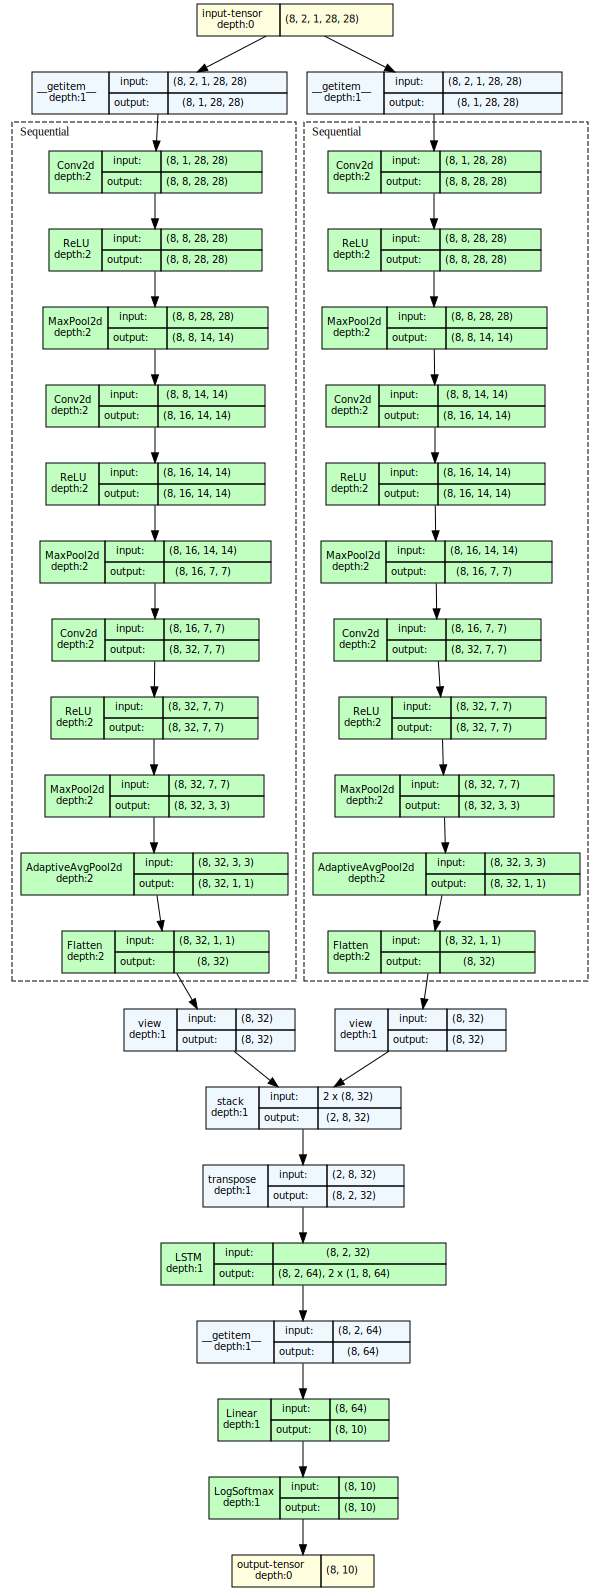

In [24]:
from torchview import draw_graph

# show graph
model_graph = draw_graph(model, input_size=x.shape, expand_nested=True)
display(model_graph.visual_graph)

In [15]:
! pip install torchinfo

In [16]:
from torchinfo import summary

summary(model, (1, 2, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 32]                   --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            80
│    └─ReLU: 2-2                         [1, 8, 28, 28]            --
│    └─MaxPool2d: 2-3                    [1, 8, 14, 14]            --
│    └─Conv2d: 2-4                       [1, 16, 14, 14]           1,168
│    └─ReLU: 2-5                         [1, 16, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 16, 7, 7]             --
│    └─Conv2d: 2-7                       [1, 32, 7, 7]             4,640
│    └─ReLU: 2-8                         [1, 32, 7, 7]             --
│    └─MaxPool2d: 2-9                    [1, 32, 3, 3]             --
│    └─AdaptiveAvgPool2d: 2-10           [1, 32, 1, 1]             --
│    └─Flatten: 2-11                     [1, 32]                   --
├─Sequent

### Training

In [17]:
def train_1epoch(model, train_loader, loss_function, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0

    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        pred = model(x)

        loss = loss_function(pred, y)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        correct += (torch.argmax(pred, dim=1) == y).sum()

    avg_loss = total_loss / len(train_loader.dataset)
    acc = correct / len(train_loader.dataset)

    return avg_loss, acc

In [18]:
def validate_1epoch(model, val_loader, loss_function, device):
    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader):
            x = x.to(device)
            y = y.to(device)

            pred = model(x)
            loss = loss_function(pred, y)

            total_loss += loss.item()
            correct += (torch.argmax(pred, dim=1) == y).sum()

    avg_loss = total_loss / len(val_loader.dataset)
    acc = correct / len(val_loader.dataset)

    return avg_loss, acc

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.NLLLoss()

100%|██████████| 157/157 [00:01<00:00, 103.56it/s]


epoch: 0, train_loss: 0.07206, acc: 0.10167, valid_loss: 0.07232, valid_acc: 0.12040


100%|██████████| 157/157 [00:02<00:00, 76.22it/s]


epoch: 1, train_loss: 0.07200, acc: 0.10487, valid_loss: 0.07197, valid_acc: 0.12220


100%|██████████| 157/157 [00:01<00:00, 108.10it/s]


epoch: 2, train_loss: 0.06118, acc: 0.26680, valid_loss: 0.04327, valid_acc: 0.52100


100%|██████████| 157/157 [00:01<00:00, 107.82it/s]


epoch: 3, train_loss: 0.02716, acc: 0.75953, valid_loss: 0.01603, valid_acc: 0.88240


100%|██████████| 157/157 [00:01<00:00, 108.66it/s]


epoch: 4, train_loss: 0.01202, acc: 0.90953, valid_loss: 0.00960, valid_acc: 0.92400


100%|██████████| 157/157 [00:01<00:00, 101.83it/s]


epoch: 5, train_loss: 0.00829, acc: 0.93393, valid_loss: 0.00798, valid_acc: 0.93480


100%|██████████| 157/157 [00:01<00:00, 109.78it/s]


epoch: 6, train_loss: 0.00641, acc: 0.94723, valid_loss: 0.00703, valid_acc: 0.93940


100%|██████████| 157/157 [00:01<00:00, 107.31it/s]


epoch: 7, train_loss: 0.00531, acc: 0.95413, valid_loss: 0.00623, valid_acc: 0.94580


100%|██████████| 157/157 [00:01<00:00, 108.39it/s]


epoch: 8, train_loss: 0.00455, acc: 0.96190, valid_loss: 0.00627, valid_acc: 0.94200


100%|██████████| 157/157 [00:01<00:00, 111.04it/s]


epoch: 9, train_loss: 0.00399, acc: 0.96530, valid_loss: 0.00636, valid_acc: 0.94340


100%|██████████| 157/157 [00:02<00:00, 70.72it/s]


epoch: 10, train_loss: 0.00360, acc: 0.96817, valid_loss: 0.00631, valid_acc: 0.94500


100%|██████████| 157/157 [00:01<00:00, 111.10it/s]


epoch: 11, train_loss: 0.00317, acc: 0.97133, valid_loss: 0.00590, valid_acc: 0.94800


100%|██████████| 157/157 [00:01<00:00, 106.76it/s]


epoch: 12, train_loss: 0.00293, acc: 0.97393, valid_loss: 0.00582, valid_acc: 0.94520


100%|██████████| 157/157 [00:01<00:00, 109.93it/s]


epoch: 13, train_loss: 0.00267, acc: 0.97670, valid_loss: 0.00617, valid_acc: 0.94340


100%|██████████| 157/157 [00:01<00:00, 110.17it/s]


epoch: 14, train_loss: 0.00249, acc: 0.97767, valid_loss: 0.00538, valid_acc: 0.94880


100%|██████████| 157/157 [00:01<00:00, 110.25it/s]


epoch: 15, train_loss: 0.00235, acc: 0.97850, valid_loss: 0.00603, valid_acc: 0.94800


100%|██████████| 157/157 [00:01<00:00, 109.96it/s]


epoch: 16, train_loss: 0.00202, acc: 0.98200, valid_loss: 0.00589, valid_acc: 0.94980


100%|██████████| 157/157 [00:01<00:00, 100.06it/s]


epoch: 17, train_loss: 0.00208, acc: 0.98057, valid_loss: 0.00555, valid_acc: 0.94980


100%|██████████| 157/157 [00:01<00:00, 109.71it/s]


epoch: 18, train_loss: 0.00190, acc: 0.98227, valid_loss: 0.00537, valid_acc: 0.95440


100%|██████████| 157/157 [00:01<00:00, 105.02it/s]


epoch: 19, train_loss: 0.00159, acc: 0.98523, valid_loss: 0.00570, valid_acc: 0.95360


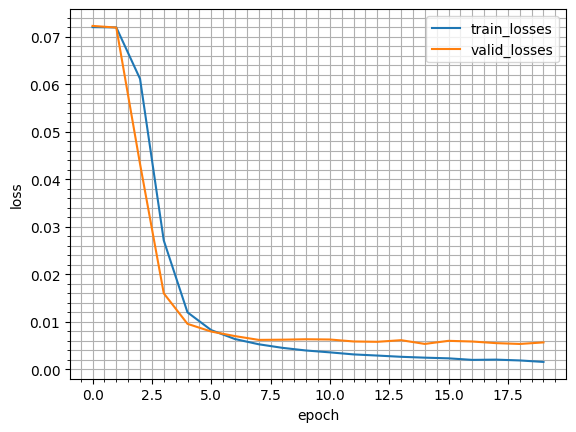

In [20]:
num_of_epochs = 20
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

model.to(device)

for epoch in range(num_of_epochs):
    loss, acc = train_1epoch(model, train_loader, loss_function, optimizer, device)
    valid_loss, valid_acc = validate_1epoch(model, valid_loader, loss_function, device)

    train_losses.append(loss)
    valid_losses.append(valid_loss)
    train_accuracy.append(acc)
    valid_accuracy.append(valid_acc)

    print(f"epoch: {epoch}, train_loss: {loss:.5f}, acc: {acc:.5f}, valid_loss: {valid_loss:.5f}, valid_acc: {valid_acc:.5f}")

plt.plot(train_losses, label="train_losses")
plt.plot(valid_losses, label="valid_losses")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.minorticks_on()
plt.grid(which="both")
plt.legend()
plt.show()

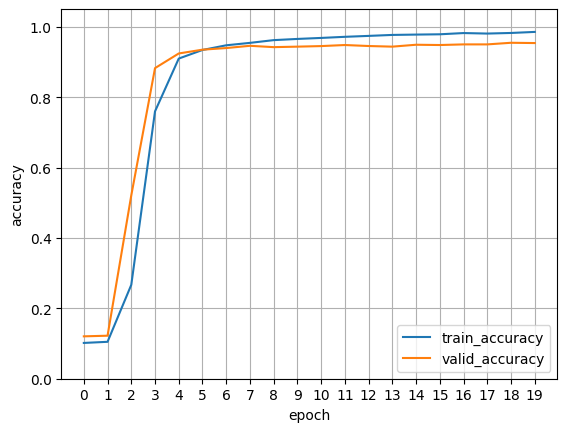

In [27]:
plt.plot(train_accuracy, label="train_accuracy")
plt.plot(valid_accuracy, label="valid_accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid()
plt.legend()
plt.ylim(0, 1.05)
plt.xticks(range(num_of_epochs))
plt.show()